In [65]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import datetime 

**Extracting Finance features from YFinance**

In [66]:
apple= yf.Ticker("aapl")
sp = yf.Ticker("^GSPC")
applep = apple.history(start="2019-01-01", end="2022-12-31", interval="1wk")
spp = sp.history(start="2019-01-01", end="2022-12-31", interval="1wk")

columns_drop = ['Dividends', 'Volume', 'Stock Splits', 'Open']
columns_drop_sp = ['Dividends', 'Volume', 'Stock Splits', 'Open', 'High', 'Low']
applep = applep.drop(columns=columns_drop)
spp = spp.drop(columns=columns_drop_sp)
applep = pd.merge(applep, spp, on="Date", how="left").reset_index()

**Extracting Finance features from AlphaVantage**

In [67]:
import requests
import json

# set the API endpoint and parameters
symbol = 'AAPL'
api_key = 'U9NBHARV1LPZMLN0'

endpoint_earning = f'https://www.alphavantage.co/query?function=EARNINGS&symbol={symbol}&apikey={api_key}'
endpoint_ics = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={symbol}&apikey={api_key}'
endpoint_bs = f'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={symbol}&apikey={api_key}'

# send a request to the API endpoint
response_e = requests.get(endpoint_earning)
response_ics = requests.get(endpoint_ics)
response_bs = requests.get(endpoint_bs)

# parse the response JSON data
data_e = json.loads(response_e.content)
data_ics = json.loads(response_ics.content)
data_bs = json.loads(response_bs.content)

# cols needed 
cols = {
    'bs': ['cashAndCashEquivalentsAtCarryingValue', 'shortLongTermDebtTotal','commonStockSharesOutstanding', 'totalLiabilities', 'totalShareholderEquity'],
    'is': ['ebitda', 'netIncome'],
    'e' : ['reportedEPS']
    }


# extract the quarterly earnings data
earnings = data_e['quarterlyEarnings']
ics = data_ics['quarterlyReports']
bs = data_bs['quarterlyReports']

# convert the earnings data to a pandas dataframe
earnings_df = pd.DataFrame.from_dict(earnings)
ics_df = pd.DataFrame.from_dict(ics)
bs_df = pd.DataFrame.from_dict(bs)

# set the date column as the index and sort the dataframe by date
earnings_df = earnings_df.set_index('reportedDate').sort_index()
ics_df = ics_df.set_index('fiscalDateEnding').sort_index()
bs_df = bs_df.set_index('fiscalDateEnding').sort_index()

# filter the dataframe based on start and end dates
start_date = '2018-04-01'
end_date = '2023-03-27'

start_date_earning = '2019-01-29'
end_date_earning = '2022-10-27'
earnings_df = earnings_df.loc[start_date_earning:end_date_earning][cols['e']]
ics_df = ics_df.loc[start_date:end_date][cols['is']]
bs_df = bs_df.loc[start_date:end_date][cols['bs']]

df = ics_df.merge(bs_df, on='fiscalDateEnding')

for col in ['ebitda','commonStockSharesOutstanding', 'totalLiabilities', 'cashAndCashEquivalentsAtCarryingValue',
           'totalShareholderEquity', 'netIncome', 'shortLongTermDebtTotal']:
    df[col] = df[col].astype('float')

df['debtToEquity'] = df['totalLiabilities'] / df['totalShareholderEquity']
df['roe'] = df['netIncome'] / df['totalShareholderEquity']
df['ev/ebitda'] = (df.commonStockSharesOutstanding + df.shortLongTermDebtTotal - df.cashAndCashEquivalentsAtCarryingValue) / df.ebitda

temp_date = pd.Series(df.index).apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
temp_date.index = df.index
df['date'] = temp_date
df['year'] = df['date'].apply(lambda x: x.year)
df['quarter'] = df['date'].apply(lambda x: x.month / 3)

temp_date1 = pd.Series(earnings_df.index).apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
temp_date1.index = earnings_df.index
earnings_df['date'] = temp_date1
earnings_df['year'] = earnings_df['date'].apply(lambda x: x.year)
earnings_df['quarter'] = earnings_df['date'].apply(lambda x: (x.month//3) +1)

print(df)

                        ebitda     netIncome  \
fiscalDateEnding                               
2018-06-30        1.679500e+10  1.151900e+10   
2018-09-30        2.004300e+10  1.412500e+10   
2018-12-31        2.819100e+10  1.996500e+10   
2019-03-31        1.784300e+10  1.156100e+10   
2019-06-30        1.571000e+10  1.004400e+10   
2019-09-30        2.011600e+10  1.368600e+10   
2019-12-31        2.951900e+10  2.223600e+10   
2020-03-31        1.667800e+10  1.124900e+10   
2020-06-30        1.658600e+10  1.125300e+10   
2020-09-30        1.823700e+10  1.267300e+10   
2020-12-31        3.688300e+10  2.875500e+10   
2021-03-31        3.147800e+10  2.363000e+10   
2021-06-30        2.786600e+10  2.174400e+10   
2021-09-30        2.690900e+10  2.055100e+10   
2021-12-31        4.463200e+10  3.463000e+10   
2022-03-31        3.356700e+10  2.501000e+10   
2022-06-30        2.659000e+10  1.944200e+10   
2022-09-30        2.834900e+10  2.072100e+10   
2022-12-31        3.954200e+10  2.999800

In [68]:
def getData(date, var ,df):
    quarter = (int(date.month - 1) // 3) + 1
    year = date.year
    return df[(df.quarter == quarter) & (df.year == year)][var].values

In [69]:
applep_new = applep.copy()
applep_new['roe'] = applep_new['Date'].apply(lambda x: getData(x,'roe', df)[0])
applep_new['debtToEquity'] = applep_new['Date'].apply(lambda x: getData(x,'debtToEquity', df)[0])
applep_new['ev/ebitda']  = applep_new['Date'].apply(lambda x: getData(x,'ev/ebitda', df)[0])
applep_new['eps'] = applep_new['Date'].apply(lambda x: getData(x,'reportedEPS', earnings_df)[0])
applep_new['dateStr'] = applep_new['Date'].dt.strftime('%Y-%m-%d')

In [70]:
# Dataframe with all the proposed features
applep_new

,Date,High,Low,Close_x,Close_y,roe,debtToEquity,ev/ebitda,eps,dateStr
0,2019-01-01 00:00:00-05:00,38.271114,34.211508,35.640198,2549.689941,0.109210,2.230663,4.457843,1.05,2019-01-01
1,2019-01-08 00:00:00-05:00,37.230303,35.782339,36.138908,2582.610107,0.109210,2.230663,4.457843,1.05,2019-01-08
2,2019-01-15 00:00:00-05:00,38.037413,36.150961,37.782032,2670.709961,0.109210,2.230663,4.457843,1.05,2019-01-15
3,2019-01-22 00:00:00-05:00,38.097641,36.548485,37.656746,2643.850098,0.109210,2.230663,4.457843,1.05,2019-01-22
4,2019-01-29 00:00:00-05:00,41.357371,37.129118,41.258591,2724.870117,0.109210,2.230663,4.457843,1.05,2019-01-29
...,...,...,...,...,...,...,...,...,...,...
204,2022-11-29 00:00:00-05:00,150.689917,140.136039,146.406464,3998.840088,0.528813,5.112557,2.692085,1.29,2022-11-29
205,2022-12-06 00:00:00-05:00,147.075443,139.786569,144.269730,3990.560059,0.528813,5.112557,2.692085,1.29,2022-12-06
206,2022-12-13 00:00:00-05:00,149.741373,131.119811,132.168198,3817.659912,0.528813,5.112557,2.692085,1.29,2022-12-13
207,2022-12-20 00:00:00-05:00,136.601432,129.442364,131.658981,3844.820068,0.528813,5.112557,2.692085,1.29,2022-12-20


In [71]:
# Print missing data
print(applep_new.isnull().sum())

Date            0
High            0
Low             0
Close_x         0
Close_y         0
roe             0
debtToEquity    0
ev/ebitda       0
eps             0
dateStr         0
dtype: int64


No missing data

In [72]:
# To observe the data types
applep_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype                           
---  ------        --------------  -----                           
 0   Date          209 non-null    datetime64[ns, America/New_York]
 1   High          209 non-null    float64                         
 2   Low           209 non-null    float64                         
 3   Close_x       209 non-null    float64                         
 4   Close_y       209 non-null    float64                         
 5   roe           209 non-null    float64                         
 6   debtToEquity  209 non-null    float64                         
 7   ev/ebitda     209 non-null    float64                         
 8   eps           209 non-null    object                          
 9   dateStr       209 non-null    object                          
dtypes: datetime64[ns, America/New_York](1), float64(7), object(2)
memory usage

In [73]:
# To observe the distribution of the data
applep_new.describe()

,High,Low,Close_x,Close_y,roe,debtToEquity,ev/ebitda
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,112.874079,105.768593,109.583881,3626.302299,0.291707,3.859217,4.794473
std,44.932220,42.012143,43.372862,634.317151,0.132405,1.006432,2.488400
min,37.230303,34.211508,35.640198,2237.399902,0.104130,2.230663,2.285845
25%,67.091091,63.679777,65.274223,3014.300049,0.155682,2.804470,2.692085
50%,126.408384,118.256522,123.337029,3677.949951,0.325741,3.957039,3.950375
75%,149.869704,141.083864,145.473495,4173.109863,0.371074,4.346309,4.937172
max,181.607116,175.968462,180.683853,4796.560059,0.528813,5.961537,10.737553


From the summary data, we don't really have outliers.


**Closing Price (Apple)**

The closing price is the last price at which the stock is traded during the regular trading day. The stock’s closing price is the standard benchmark used by investors to track its performance over time.

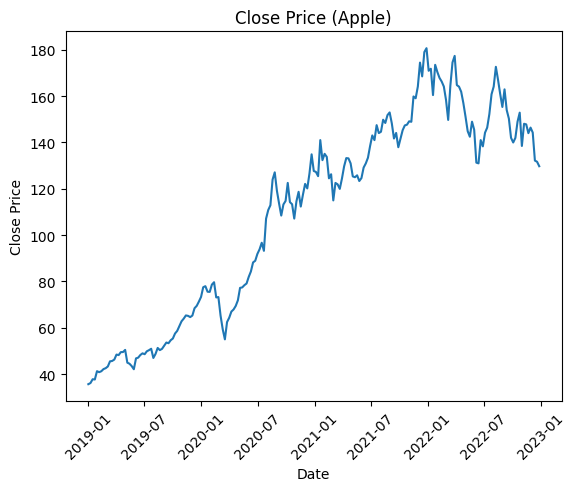

In [74]:
plt.plot(applep_new['Date'], applep_new['Close_x'])
plt.title('Close Price (Apple)')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Close Price')
plt.show()

From the Linechart, we can see that the general trend of the Apple Stock Price is increasing. However, we can see a slight drop in 2022.

**Closing Price (S&P)**

We used S&P as a benchmark index of the US stock market since it is composed of 500 large-cap stocks from various sectors, which indicates how the market is doing generally.

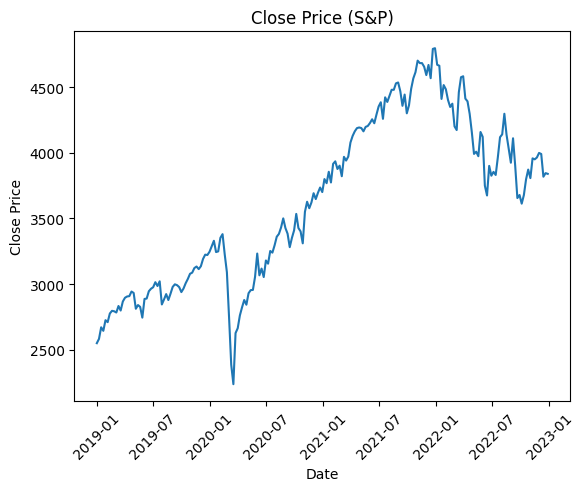

In [75]:
plt.plot(applep_new['Date'], applep_new['Close_y'])
plt.title('Close Price (S&P)')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Close Price')
plt.show()

From the Linechart, we can see that the general trend of the S&P Closing Price is increasing, with a sharp drop in early 2020 due to the COVID-19 pandemic. It is also decreasing slightly over the recent years due to economic downturn.

**Return on Equity (ROE)**

ROE is a ratio that measures the profitability of a company by calculating how much profit it generates for each dollar of shareholder equity.

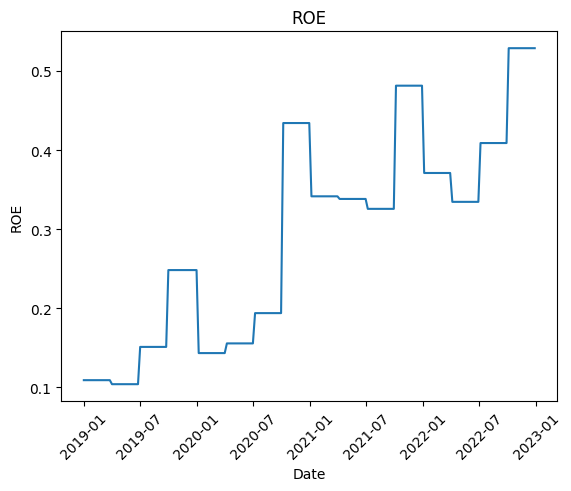

In [76]:
plt.plot(applep_new['Date'], applep_new['roe'])
plt.title('ROE')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('ROE')
plt.show()

From the Linechart, there is an increasing trend for Apple's ROE, which means that the company is generating more profit with each dollar of equity, which is seen as a positive sign for investors.

**Debt to Equity (D/E Ratio)**

The D/E Ratio measure a company's debt to shareholder's equity and calculated by dividing a company's total liabilities by its total shareholder equity.

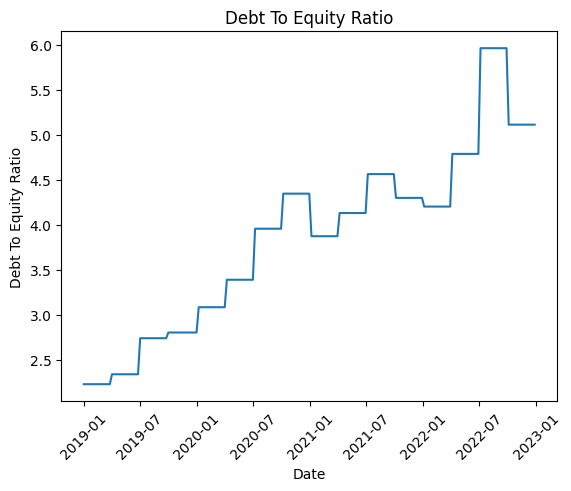

In [77]:
plt.plot(applep_new['Date'], applep_new['debtToEquity'])
plt.title('Debt To Equity Ratio')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Debt To Equity Ratio')
plt.show()

From the Linechart, we can see that the general trend of the Debt to Equity ratio is increasing. This means that Apple could be relying more on debt to finance share buybacks and increase dividends.

**Enterprise Multiple (EV/EBITDA)**

The Enterprise Multiple is the Enterprise Value (EV) divided by the Earnings before interest, taxes, depreciation and amortization (EBITDA). EV calculates the company's total value or assessed worth, while EBITDA measures a company's overall financial performance and profitability. The Enterprise Multiple is a ratio used to determine the value of a company.

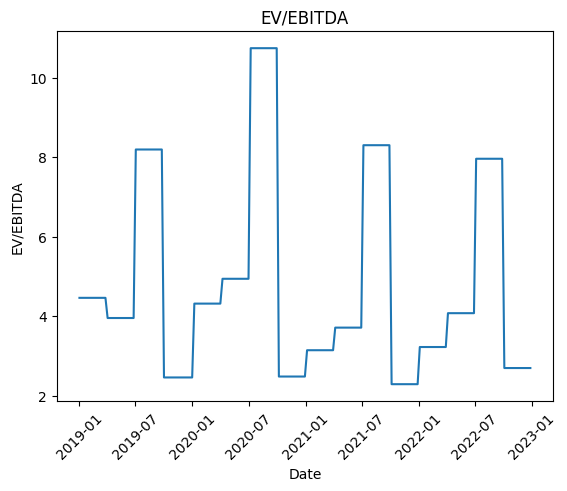

In [78]:
plt.plot(applep_new['Date'], applep_new['ev/ebitda'])
plt.title('EV/EBITDA')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('EV/EBITDA')
plt.show()

From the Linechart, we can see that Apple's Enterprise Multiple is generally decreasing, which could be due to its earnings increasing over time while enterprise value remaining relatively constant.

**Earnings per Share (EPS)**

The earnings per share is the company's net profit divided by the number of common shares it has outstanding. The EPS signals the profitability of the company.

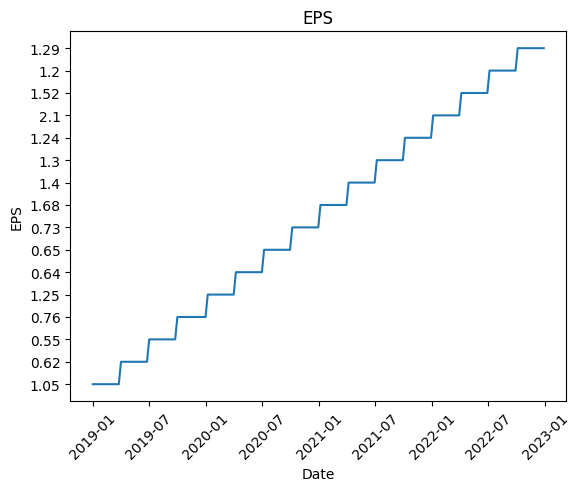

In [79]:
plt.plot(applep_new['Date'], applep_new['eps'])
plt.title('EPS')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('EPS')
plt.show()

From the Linechart, we can see that the general trend of Apple's EPS is increasing, indicating its increasing profitability and revenue growth.

**Correlations between features**

We want to observe the pairwise correlation between features, to see their relationship and whether some features are highly correlated.

In [80]:
data_corr = pd.DataFrame()
data_corr['High'] = applep_new['High']
data_corr['Low'] = applep_new['Low']
data_corr['Close_x'] = applep_new['Close_x']
data_corr['Close_y'] = applep_new['Close_y']
data_corr['roe'] = applep_new['roe']
data_corr['debtToEquity'] = applep_new['debtToEquity']
data_corr['ev/ebitda'] = applep_new['ev/ebitda']
data_corr['eps'] = applep_new['eps']
corr_matrix = data_corr.corr()
print(corr_matrix)

                  High       Low   Close_x   Close_y       roe  debtToEquity  \
High          1.000000  0.996344  0.996856  0.921111  0.843545      0.892174   
Low           0.996344  1.000000  0.997238  0.936716  0.846186      0.885897   
Close_x       0.996856  0.997238  1.000000  0.933104  0.844388      0.887333   
Close_y       0.921111  0.936716  0.933104  1.000000  0.788766      0.736690   
roe           0.843545  0.846186  0.844388  0.788766  1.000000      0.824649   
debtToEquity  0.892174  0.885897  0.887333  0.736690  0.824649      1.000000   
ev/ebitda    -0.055432 -0.064033 -0.057042 -0.126698 -0.337726      0.107166   

              ev/ebitda  
High          -0.055432  
Low           -0.064033  
Close_x       -0.057042  
Close_y       -0.126698  
roe           -0.337726  
debtToEquity   0.107166  
ev/ebitda      1.000000  


From the correlation matrix, we can see a few features that are highly correlated, namely, High, Low and Close_x. However, we have decided to use all these features as these are the most important features in predicting future stock prices.